# Trotterization with light-cone ordering (short-time)

In [1]:
from qiskit.quantum_info import SparsePauliOp, random_statevector
from functools import partial
import multiprocessing
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd
import scipy, jax

import matplotlib.pyplot as plt
import numpy as np

from utils import *
from spin_ham import *
from trotter import *
from bounds import *
from dqpt  import *

figs_dir, data_dir = './figs', './data'

color_cycle = ["#E64B35FF", "#00BFAEFF", "#0A75C7FF", "#F39B7FFF", "#4DBBD5FF", "#FFAA00FF", "k"]
colors = mpl.cycler(color=color_cycle, alpha=[.9] * len(color_cycle)) 
mpl.rc('axes', prop_cycle=colors)

## Nearest-neighbor Heisenberg model

In [2]:
prefix, suffix = 'NNH', 'n'  # 'TFI', 'n'
use_jax = True
n_bnd_max = 400 # 400,  100,  200,  250
n_list_bnd = [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 198, 248, 310][:-5]

r_max = n_bnd_max
n_max, n_min = 10, 6  #  9, 5 ;  12, 5 
J, h, g = 1, 0.5, 1.2 # 1, 1 ;  0.2, 0.2 ;  1, 0.2
t, eps = 0.1, 0.001

field_list = [0 for _ in range(n_bnd_max)]
# field_list = [random.gauss(0, 0.1) for _ in range(n_bnd_max)]
# print('random field: ', field_list)
n_list_emp = np.arange(n_min, n_max+1)
print('n_list_bnd: ', n_list_bnd)
print('n_list_emp: ', n_list_emp)

n_list_bnd:  [6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105]
n_list_emp:  [ 6  7  8  9 10]


In [3]:
data_keys = ['worst', 'singl', 'multi', 'n']
bnd_data = dict([(k, []) for k in data_keys])
emp_data = dict([(k, []) for k in data_keys])
bnd_data['n'], emp_data['n'] = n_list_bnd, n_list_emp

r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd = 1, 1, 1
r_end_worst_bnd, r_end_singl_bnd, r_end_multi_bnd = r_max-1, r_max-1, r_max-1

import multiprocess as mp
PROCESSES = 10
for i, n in enumerate(n_list_bnd):
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=h, hy=g, hz=0, pbc=False, rand_field=field_list)
    # r_start, r_end = 1, int(n/2)
    print(f'-------------- n (bound) = {n} --------------')
    bnd_worst_err_r = partial(measure_error, h_list=hnn.ham_xyz[:2], t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, hnn])
    
    r_worst_bnd = binary_search_r(r_start_worst_bnd, r_end_worst_bnd, eps, bnd_worst_err_r, comment='worst_bnd',verbose=True)
    r_end_worst_bnd, r_end_singl_bnd, r_end_multi_bnd = r_worst_bnd+10, r_worst_bnd, r_worst_bnd
    # bnd_worst_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, cmm_data])
    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, tail_cmm_data])
    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, hnn, 0, 0])
    right, left = 0, 0
    print('prepare single ob table...')
    def singl_ob_cmm(j):
        h_list_z = lc_group(hnn, right, left, 2*j, verbose=False, legacy=True)
        c1_cmm_z, c2_cmm_z = nested_commutator_norm(h_list_z)
        return c1_cmm_z, c2_cmm_z
        # return 2 * (c1_cmm_z * dt**3 / 12 + c2_cmm_z * dt**3 / 24)
    with mp.Pool(PROCESSES) as pool:
        singl_data= pool.map(singl_ob_cmm, range(1, r_end_singl_bnd+1))
    # print('singl_data: ', singl_data)

    print('prepare multi ob table...')
    def multi_z_cmm(j):
        # h_list_z_list = [lc_group(hnn, i, i, 2*j+2, verbose=False) for i in range(0, n)]
        h_list_zz_list = [lc_group(hnn, i, i+1, 2*j+2, verbose=False) for i in range(0, n-1)]
        # tail_cmm_data = np.array([nested_commutator_norm(h_list_z) for h_list_z in h_list_z_list])
        tail_cmm_data = np.array([nested_commutator_norm(h_list_zz) for h_list_zz in h_list_zz_list])
        return tail_cmm_data
        # return 2 * (c1_cmm_z * dt**3 / 12 + c2_cmm_z * dt**3 / 24)
    with mp.Pool(PROCESSES) as pool:
        multi_z_data= pool.map(multi_z_cmm, range(1, r_end_multi_bnd+1))
    # print('multi_z_data: ', multi_z_data)
    # print(r_end_singl_bnd, r_end_multi_bnd)

    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, hnn, 0, 0])
    # bnd_multi_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['multi_zz', n, hnn, 0, 0])
    bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound_table', coeffs=['singl', n, singl_data])
    bnd_multi_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound_table', coeffs=['multi_zz', n, multi_z_data])

    r_singl_bnd = binary_search_r(r_start_singl_bnd, r_end_singl_bnd, eps, bnd_singl_err_r, comment='singl_bnd',verbose=True)
    r_multi_bnd = binary_search_r(r_start_multi_bnd, r_end_multi_bnd, eps, bnd_multi_err_r, comment='multi_bnd',verbose=True)
    bnd_data['worst'].append(r_worst_bnd)
    bnd_data['singl'].append(r_singl_bnd)
    bnd_data['multi'].append(r_multi_bnd)
    r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd = r_worst_bnd, r_singl_bnd, r_multi_bnd

r_start_worst_emp, r_start_singl_emp, r_start_multi_emp, r_end = 1, 1, 1, r_max-1
for n in n_list_emp:
    print(f'-------------- n (empirical) = {n} --------------')
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=0, hy=0, hz=h, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list)
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=h, hy=g, hz=0, pbc=False, rand_field=field_list)
    # field_list = hnn.rand_field
    singl_ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Y', [i], 1) for i in range(0, n)], n).to_matrix()
    multi_ob = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1) for i in range(0, n-1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([(random.choice(['X','Y','Z']), [i], 1) for i in range(0, n)], n).to_matrix()
    print('multi ob norm: ', np.linalg.norm(multi_ob, ord=2))
    multi_ob = multi_ob / np.linalg.norm(multi_ob, ord=2)
    par_group = [h.to_matrix() for h in hnn.ham_par]
    # par_group = [h.to_matrix() for h in hnn.ham_par][::-1]
    xyz_group = [h.to_matrix() for h in hnn.ham_xyz]

    exact_U = jax.scipy.linalg.expm(-1j * t * sum([h for h in par_group]))
    # verfiy the exact_U
    assert np.allclose(exact_U, jax.scipy.linalg.expm(-1j * t * sum([h for h in xyz_group])))

    emp_worst_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_empirical', use_jax=use_jax)
    emp_singl_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=singl_ob, type='worst_ob_empirical', use_jax=use_jax)
    emp_multi_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=multi_ob, type='worst_ob_empirical', use_jax=use_jax)

    r_worst_emp = binary_search_r(r_start_worst_emp, r_end, eps, emp_worst_err_r, comment='worst_emp', verbose=True)
    r_singl_emp = binary_search_r(r_start_singl_emp, r_end, eps, emp_singl_err_r, comment='singl_emp',verbose=True)
    r_multi_emp = binary_search_r(r_start_multi_emp, r_end, eps, emp_multi_err_r, comment='multi_emp',verbose=True)
    emp_data['worst'].append(r_worst_emp)
    emp_data['singl'].append(r_singl_emp)
    emp_data['multi'].append(r_multi_emp)
    r_start_worst_emp, r_start_singl_emp, r_start_multi_emp = r_worst_emp, r_singl_emp, r_multi_emp

print('emp_data: ', emp_data)
# print(pd.DataFrame(emp_data))
# save to csv
pd.DataFrame(emp_data).to_csv(f'{data_dir}/{prefix}_emp_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data).to_csv(f'{data_dir}/{prefix}_bnd_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data)

-------------- n (bound) = 6 --------------
----[worst_bnd] binary search r (r_start=1, r_end=399)----
r_start: 1 ; r_end: 200
r_start: 1 ; r_end: 100
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 1 ; r_end: 7
r_start: 4 ; r_end: 7
r_start: 5 ; r_end: 7
r_start: 5 ; r_end: 6
r: 6 ; err:  0.0009622222222222222
prepare single ob table...
prepare multi ob table...
----[singl_bnd] binary search r (r_start=1, r_end=6)----
r_start: 3 ; r_end: 6
r_start: 3 ; r_end: 4
r: 4 ; err:  0.0007956249999999999
----[multi_bnd] binary search r (r_start=1, r_end=6)----
r_start: 3 ; r_end: 6
r_start: 4 ; r_end: 6
r_start: 4 ; r_end: 5
r: 5 ; err:  0.0006456000000000001
-------------- n (bound) = 7 --------------
----[worst_bnd] binary search r (r_start=6, r_end=16)----
r_start: 6 ; r_end: 11
r_start: 6 ; r_end: 8
r_start: 6 ; r_end: 7
r: 7 ; err:  0.0008530612244897961
prepare single ob table...
prepare multi ob table...
----[singl_bnd] binary search r (r_start=4, r_end=7)-

,worst,singl,multi,n
0,6,4,5,6
1,7,4,5,7
2,7,4,5,8
3,8,5,5,9
4,8,5,6,10
5,9,5,6,12
6,10,5,6,15
7,11,5,7,18
8,13,5,7,23
9,15,5,8,29


bnd_data: 
     worst  singl  multi    n
0       6      4      5    6
1       7      4      5    7
2       7      4      5    8
3       8      5      5    9
4       8      5      6   10
5       9      5      6   12
6      10      5      6   15
7      11      5      7   18
8      13      5      7   23
9      15      5      8   29
10     16      5      8   36
11     18      5      8   44
12     20      5      9   55
13     22      5      9   68
14     25      5      9   84
15     28      5      9  105
emp_data: 
    worst  singl  multi   n
0      3      2      2   6
1      3      2      2   7
2      3      2      2   8
3      4      2      2   9
4      4      2      2  10
a_em: 1.528572938117129; b_em: 2.673389842305252
a_em: 1.118098953301827; b_em: 3.465323209279453
a_em: 1.244767266703637e-08; b_em: 5.347107482035189
a_em: 0.9999999999999997; b_em: 2.484906649788001
a_em: -7.336830698534413e-09; b_em: 3.8712010326641146


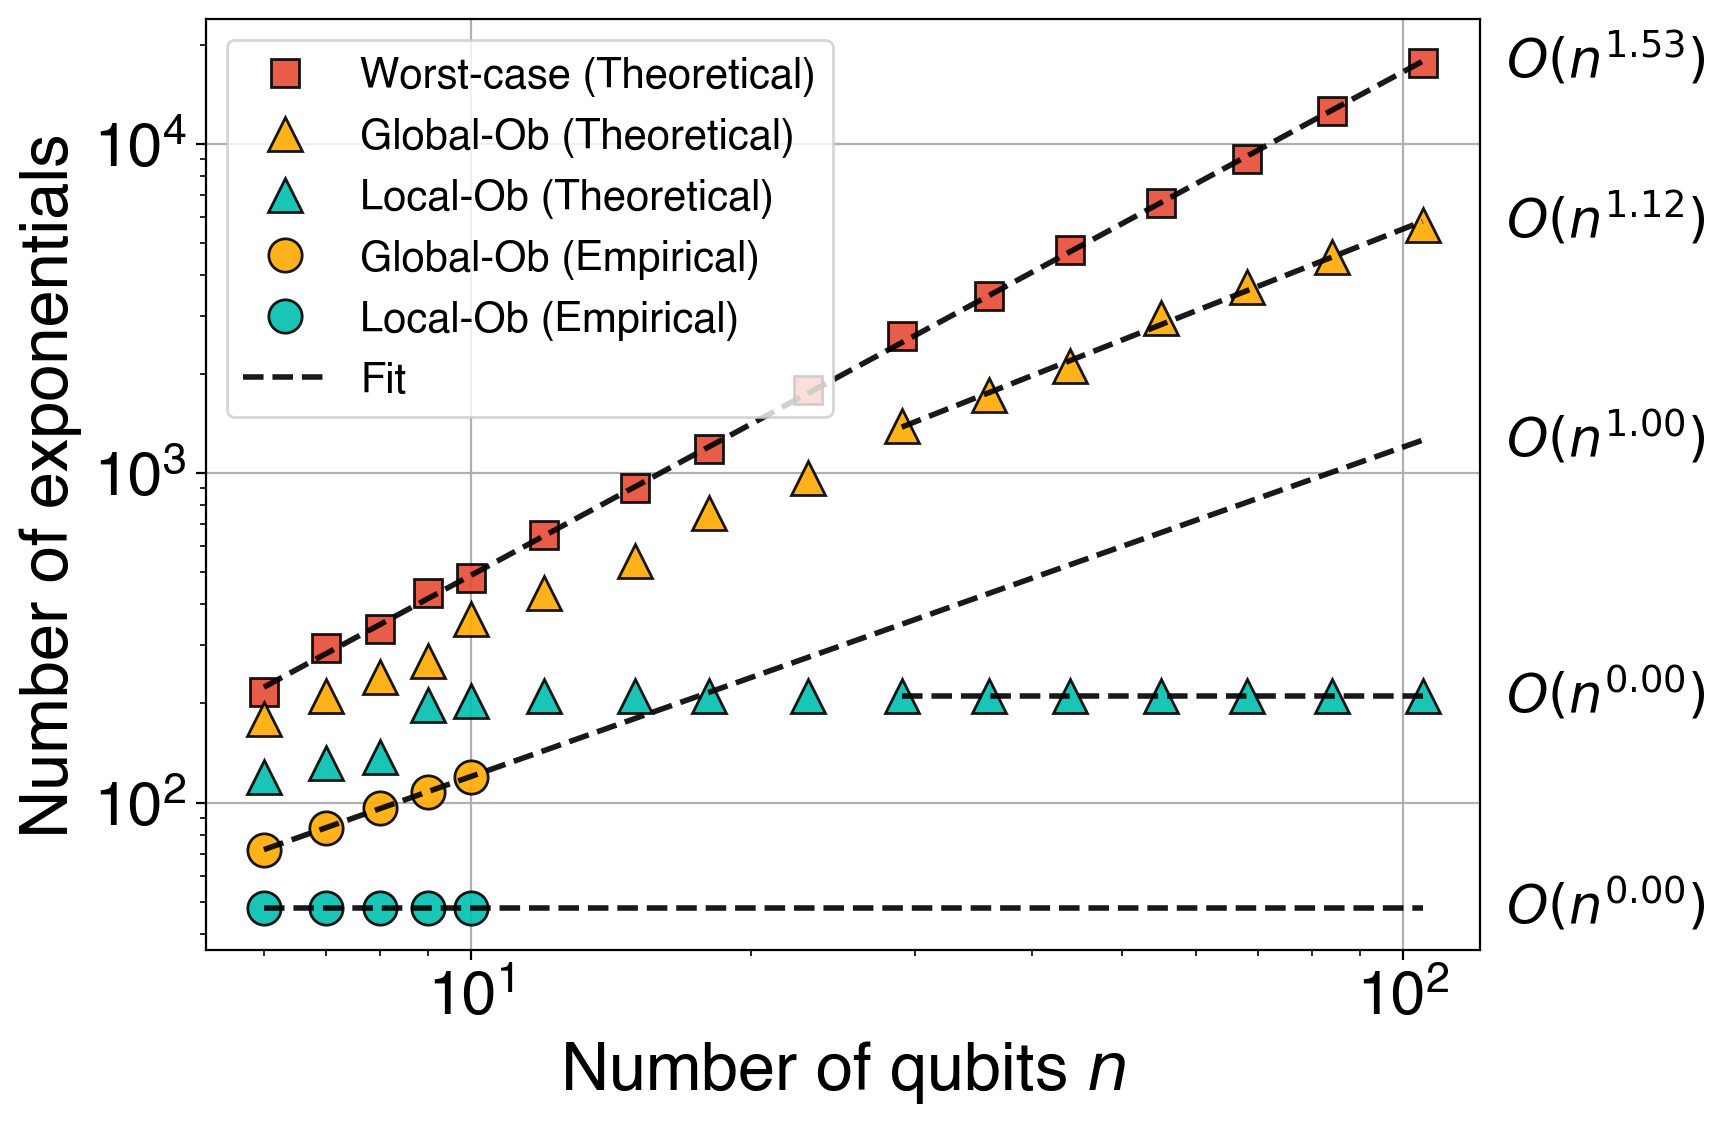

In [4]:
markersize_shift = 0

if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

emp_data = pd.read_csv(f'{data_dir}/{prefix}_emp_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv')
bnd_data = pd.read_csv(f'{data_dir}/{prefix}_bnd_lightcone_nmin={n_min}_nmax={n_max}_nbndmax={n_list_bnd[-1]}_{suffix}.csv')
print('bnd_data: \n', bnd_data)
print('emp_data: \n', emp_data)

cost_st_list = [exp_count(r, bnd_data['n'][i], factor, 'ST') for i, r in enumerate(bnd_data['worst'])]
cost_lc_list_s = [exp_count(r, bnd_data['n'][i], factor, 'LC') for i, r in enumerate(bnd_data['singl'])]
cost_lc_list_m = [exp_count(r, bnd_data['n'][i], factor, 'ST') for i, r in enumerate(bnd_data['multi'])]
cost_em_list_s = [exp_count(r, emp_data['n'][i], factor, 'LC') for i, r in enumerate(emp_data['singl'])]
cost_em_list_m =  [exp_count(r, emp_data['n'][i], factor, 'ST') for i, r in enumerate(emp_data['multi'])]
cost_em_list_w =  [exp_count(r, emp_data['n'][i], factor, 'ST') for i, r in enumerate(emp_data['worst'])]

fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
# ob_string = 'XIII'
ax2.plot(n_list_bnd, cost_st_list, 's', color='#E64B35FF', label=r'Worst-case (Theoretical)', markersize=10-markersize_shift)
plot_fit(ax2, n_list_bnd[0:], cost_st_list[0:], var=suffix, x_offset=1.23, y_offset=0.9)
# # ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list_bnd, cost_lc_list_m, '^', color=color_cycle[5], label='Global-Ob (Theoretical)', markersize=12-markersize_shift)
plot_fit(ax2, n_list_bnd[-7:], cost_lc_list_m[-7:], var=suffix, x_offset=1.23, y_offset=0.9)
ax2.plot(n_list_bnd, cost_lc_list_s, '^', color=color_cycle[1], label='Local-Ob (Theoretical)', markersize=12-markersize_shift)
plot_fit(ax2, n_list_bnd[-7:], cost_lc_list_s[-7:], var=suffix, x_offset=1.23, y_offset=0.9)
# plot_fit(ax2, n_list_bnd[2:9], cost_lc_list_m[2:9], var=suffix, x_offset=1.06, y_offset=0.8)
# ax2.plot(n_list_emp, cost_em_list_w, 'D', color='#E64B35FF', label=r'Worst-case (Empirical)', markersize=10)
ax2.plot(n_list_emp, cost_em_list_m, 'o', color=color_cycle[5], label='Global-Ob (Empirical)', markersize=12-markersize_shift)
plot_fit(ax2, n_list_emp[-4:], cost_em_list_m[-4:], var=suffix, x_offset=1.23, y_offset=0.9, ext_x=n_list_bnd)
ax2.plot(n_list_emp, cost_em_list_s, 'o', color=color_cycle[1], label='Local-Ob (Empirical)', markersize=12-markersize_shift)
plot_fit(ax2, n_list_emp[-4:], cost_em_list_s[-4:], var=suffix, x_offset=1.23, y_offset=0.9, ext_x=n_list_bnd, label='Fit')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel(f'Number of qubits $n$')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'{prefix} Heisenberg (J={J}, h={h}, fix t={t}, $\epsilon$={eps}) PF2')  
ax2.loglog();  # ax2.set_xscale('log', base=20); # ax2.set_yscale('log', base=10)
ax2.grid(); ax2.legend(loc='upper left')
# fig.savefig(f'{figs_dir}/lightcone_NNH1d_J={J}_h={h}_n={n_list_emp[-1]}_nbnd={n_list_bnd[-1]}_eps={eps}_t={t}_2r.pdf', bbox_inches='tight')